## Predicting neural spike times from hippocampal local field potential features and mouse spatial position
Running the model on the Allen Brain dataset.    
Linear regression model with **inputs : [mouse spatial position, hippocampal LFP theta]** attempting to predict **output : [neural spike timings]**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import butter, filtfilt
from scipy.signal import hilbert

In [4]:
# load in data
lfp_data = pd.read_csv("/Users/hannahghaffari/Documents/Mehta_lab/ecephys_cache_dir/session_746083955/probe_760647913_lfp_data.csv")
velocity_data = pd.read_csv("/Users/hannahghaffari/Documents/Mehta_lab/ecephys_cache_dir/session_746083955/running_speed_data.csv")
spikes = pd.read_csv("/Users/hannahghaffari/Documents/Mehta_lab/ecephys_cache_dir/session_746083955/spike_times_hipp.csv")

Text(0.5, 1.0, 'raw LFP data over time')

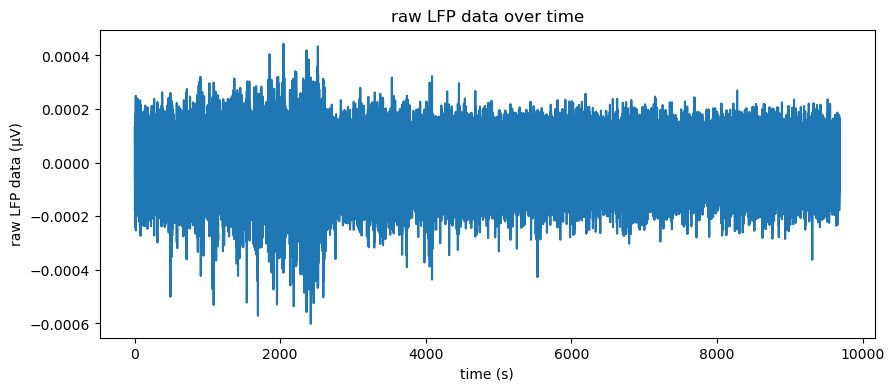

In [5]:
# visualize raw LFP data
lfp_data_tot = lfp_data[lfp_data.columns[2:]]
lfp_data_tot = lfp_data_tot.mean(axis=1)

lfp_tot = pd.DataFrame({
    'timestamp': lfp_data['Timestamp'],
    'LFP_data_avg': lfp_data_tot
})

plt.figure(figsize=(10,4))
plt.plot(lfp_tot['timestamp'], lfp_tot['LFP_data_avg'])
plt.xlabel('time (s)')
plt.ylabel('raw LFP data (µV)')
plt.title('raw LFP data over time')

Text(0.5, 1.0, 'zoomed raw LFP data over time')

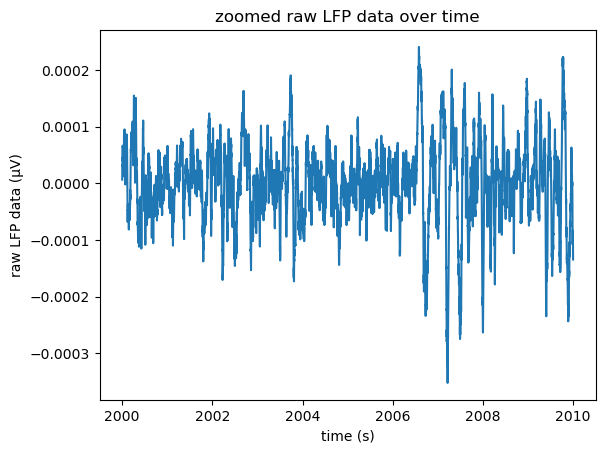

In [6]:
# zoomed raw LFP data
zoom = (lfp_tot['timestamp'] >= 2000) & (lfp_tot['timestamp'] <= 2010)
plt.plot(lfp_tot['timestamp'][zoom], lfp_tot['LFP_data_avg'][zoom])
plt.xlabel('time (s)')
plt.ylabel('raw LFP data (µV)')
plt.title('zoomed raw LFP data over time')

In [8]:
# extract LFP theta phase from raw LFP
# bandpass filter theta 4-12 Hz
def bandpass_filter(data, fs, lowcut=4, highcut=12, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# subset LFP for desired channels in hippocampus
# hippocampal locations = CA1, CA2, CA3
hipp_cols = [col for col in lfp_data.columns if any(col.startswith(f'Ch{i}_') for i in range(27, 57))]
lfp_subset = lfp_data[hipp_cols]
lfp_theta = bandpass_filter(lfp_subset, fs = 1250.002) # fs is lfp sampling rate

In [9]:
# average theta-filtered LFP signals across multiple channels
# get a representative theta phase from local population of neurons
lfp_theta_avg = lfp_theta.mean(axis=1)

# get theta phase using hilbert transform
analytic_signal = hilbert(lfp_theta_avg)
theta_phase = np.angle(analytic_signal)

df_theta_phase = pd.DataFrame({
    'timestamp': lfp_data['Timestamp'],
    'theta_phase': theta_phase
})

Text(0.5, 1.0, 'zoomed theta phase over time')

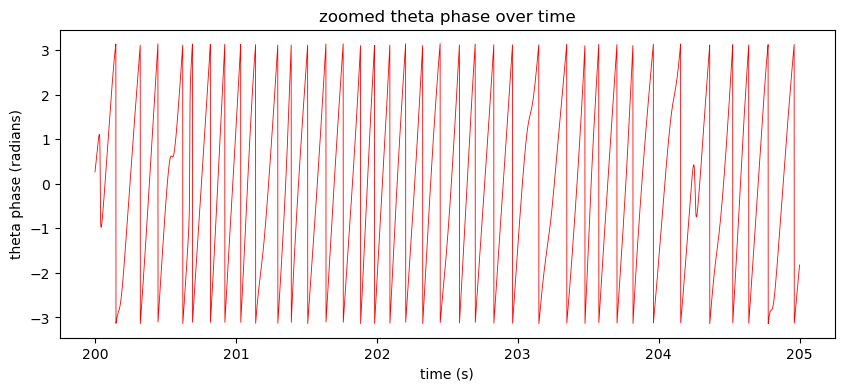

In [11]:
# visualize LFP theta phase
zoom = (df_theta_phase['timestamp'] >= 200) & (df_theta_phase['timestamp'] <= 205)
plt.figure(figsize=(10,4))
plt.plot(df_theta_phase['timestamp'][zoom], df_theta_phase['theta_phase'][zoom], linewidth = 0.6, color = 'red')
plt.xlabel('time (s)')
plt.ylabel('theta phase (radians)')
plt.title('zoomed theta phase over time')

In [13]:
# integrate velocity over time to get spatial position
pos = [0]
for i in range(len(velocity_data)):
    dt = velocity_data.loc[i, 'end_time'] - velocity_data.loc[i, 'start_time']
    new_pos = pos[-1] + velocity_data.loc[i, 'velocity'] * dt
    pos.append(new_pos)

timestamps = (velocity_data['start_time'] + velocity_data['end_time'])/2

df_position = pd.DataFrame({
    'timestamp': timestamps,
    'position': pos[:-1]
})

     unit_id  spike_time
0  951867730    3.812179
1  951867730    3.833245
2  951867730    3.854945
3  951867730    3.892712
4  951867730    3.921178
   timestamp  theta_phase
0   3.805979    -1.940850
1   3.806779    -1.734946
2   3.807579    -1.634923
3   3.808379    -1.546941
4   3.809179    -1.469507
   timestamp  position
0  34.742780  0.000000
1  34.758850  0.009312
2  34.792140  0.014245
3  34.825545  0.007258
4  34.858945  0.028980


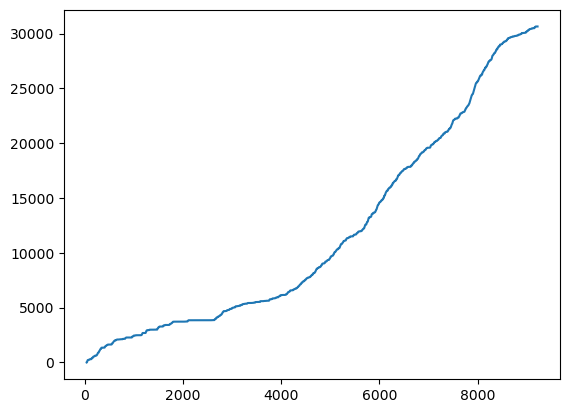

In [18]:
print(spikes.head())
print(df_theta_phase.head())
print(df_position.head())
plt.plot(df_position['timestamp'], df_position['position'])

In [25]:
# merge the dataframes with approx time alignment
# create the input df for the model

df_spikes = spikes.sort_values(by = "spike_time")

merged_df = pd.merge_asof(df_spikes, df_theta_phase, left_on = 'spike_time', right_on = 'timestamp', tolerance = 0.01, direction = 'nearest')
merged_df = pd.merge_asof(merged_df, df_position, left_on = 'spike_time', right_on = 'timestamp', tolerance = 0.01, direction = 'nearest')

merged_df.isnull().values.any() # check for NaNs
clean_df = merged_df.dropna()

input_df = clean_df[['theta_phase', 'position', 'spike_time']].reset_index(drop = True)
input_df.head()

,theta_phase,position,spike_time
0,-2.176530,0.000000,34.746801
1,-1.602791,0.009312,34.758301
2,-1.296633,0.009312,34.764167
3,-0.435726,0.014245,34.784001
4,-0.218862,0.014245,34.789767


In [28]:
# train regression model

X = input_df[['theta_phase', 'position']]
y = input_df['spike_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [29]:
# test error
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2}')

MSE: 605752.9281586307
RMSE: 778.3013093645872
R^2: 0.9181897655316297


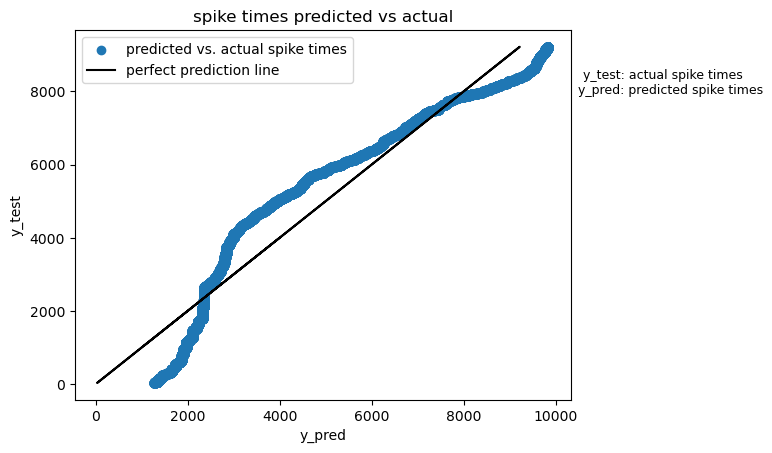

In [30]:
# visualize results
plt.scatter(y_pred, y_test, label = "predicted vs. actual spike times", color = 'tab:blue')
plt.plot(y_test, y_test, label = "perfect prediction line", color = "black")
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.title("spike times predicted vs actual")
plt.figtext(1.2, 0.8, "y_test: actual spike times     \n" + "y_pred: predicted spike times", 
            ha = "right", va = "top", fontsize = 9)
plt.legend()
plt.show()

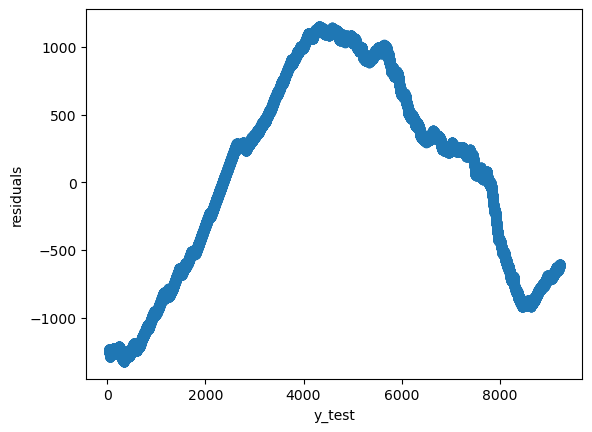

In [31]:
# residuals plot
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel("y_test")
plt.ylabel("residuals")
plt.show()

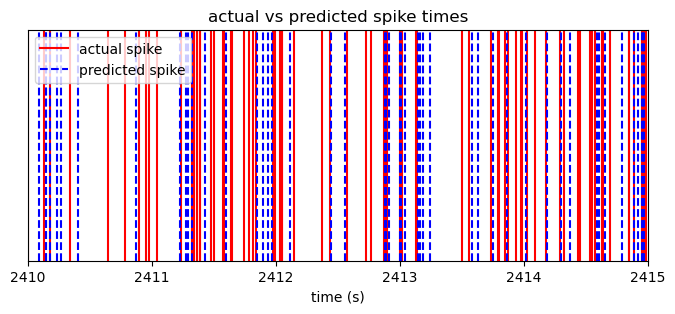

In [34]:
# visualize y_test vs y_pred spike predictions over time

start_time = 2410
end_time = 2415

y_test = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred)

actual_spikes = y_test[(y_test >= start_time) & (y_test <= end_time)]
predicited_spikes = y_pred[(y_pred >= start_time) & (y_pred <= end_time)]

plt.figure(figsize=[8,3])
for i in actual_spikes:
    plt.axvline(i, color = "red", linestyle = "-", label = "actual spike" if i == actual_spikes.iloc[0] else "")
for i in predicited_spikes:
    plt.axvline(i, color = "blue", linestyle = "--", label = "predicted spike" if i == predicited_spikes.iloc[0] else "")

plt.xlim(start_time, end_time)
plt.yticks([])
plt.xlabel('time (s)')
plt.title('actual vs predicted spike times')
plt.legend(loc = 'upper left')
plt.show()

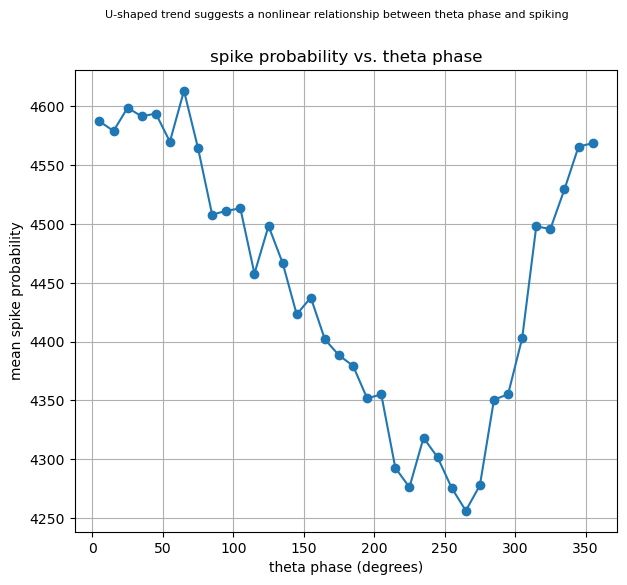

In [38]:
# conclusion - testing linearity of the variables for discussion

input_df
input_df["theta_phase_deg"] = np.degrees(input_df["theta_phase"]) % 360

bins = np.linspace(0, 360, 37)
input_df["theta_binned"] = pd.cut(input_df["theta_phase_deg"], bins)

binned = input_df.groupby("theta_binned")["spike_time"].mean()

bin_centers = [interval.mid for interval in binned.index]

plt.figure(figsize=[7,6])
plt.plot(bin_centers, binned.values, marker = "o")
plt.xlabel("theta phase (degrees)")
plt.ylabel("mean spike probability")
plt.title("spike probability vs. theta phase")
plt.suptitle("U-shaped trend suggests a nonlinear relationship between theta phase and spiking", fontsize = 8)
plt.grid(True)
plt.show()

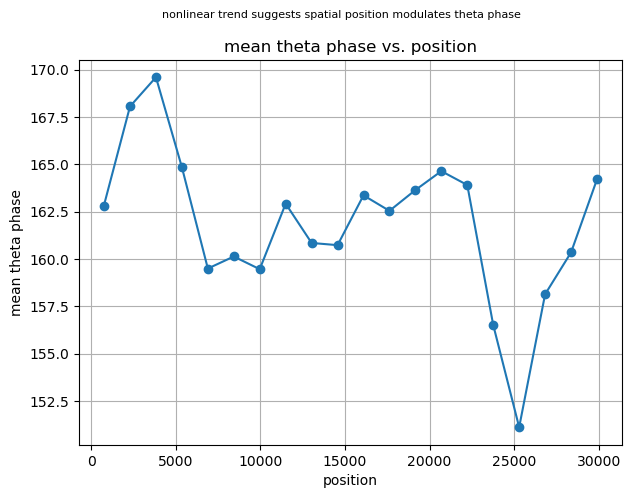

In [40]:
input_df["pos_bin"] = pd.cut(input_df["position"], bins = 20)

binned_theta = input_df.groupby("pos_bin")["theta_phase_deg"].mean()

bin_pos_cents = [interval.mid for interval in binned_theta.index]

plt.figure(figsize=[7,5])
plt.plot(bin_pos_cents, binned_theta.values, marker = "o")
plt.xlabel("position")
plt.ylabel("mean theta phase")
plt.title("mean theta phase vs. position")
plt.suptitle("nonlinear trend suggests spatial position modulates theta phase", fontsize = 8)
plt.grid(True)
plt.show()